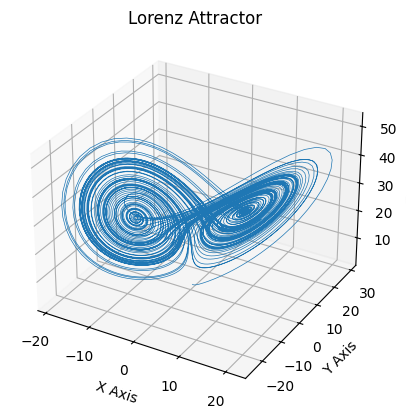

In [23]:
import numpy as np
import matplotlib.pyplot as plt
def lorenz(xyz, *, s=10, r=28, b=2.667):
    """
    Parameters
    ----------
    xyz : array-like, shape (3,)
       Point of interest in three-dimensional space.
    s, r, b : float
       Parameters defining the Lorenz attractor.

    Returns
    -------
    xyz_dot : array, shape (3,)
       Values of the Lorenz attractor's partial derivatives at *xyz*.
    """
    x, y, z = xyz
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return np.array([x_dot, y_dot, z_dot])

# 00, 01, 02, 11, 12, 22
init_2nd = [
    [ 0, 0, 0, 0, 0, 0],
    [ 0, 0, -1.0, 0, 0, 0],
    [ 0, 1.0, 0, 0, 0, 0]
]
# 0, 1, 1
init_1st = [
    [-10, 10, 0],
    [28, -1.0, 0],
    [0, 0, -2.667]
]

init_vars = []
for vl in init_2nd:
    for v in vl:
        init_vars.append(v)
for vl in init_1st:
    for v in vl:
        init_vars.append(v)
        

init_vars = np.array(init_vars)

dt = 0.01
num_steps = 10000

data = np.empty((num_steps + 1, 3))  # Need one more for the initial values
data[0] = (0., 1., 1.05)  # Set initial values
# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point

for i in range(num_steps):
    data[i + 1] = data[i] + lorenz(data[i].copy()) * dt

# Plot
ax = plt.figure().add_subplot(projection='3d')

ax.plot(*data.T, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

In [24]:
import copy
saved_data = copy.copy(data)

In [5]:

x_ = np.linspace(-120, 120, 30)
y_ = np.linspace(-125., 125., 30)
z_ = np.linspace(-85., 305., 30)

import itertools
init_start = list(map(lambda b: b, itertools.product(x_,y_,z_)))

In [10]:
def apply_w(X, w_tensor):
        
    D = X
    x_2 = w_tensor[0]
    y_2 = w_tensor[1]
    z_2 = w_tensor[2]
    x_1 = w_tensor[3]
    y_1 = w_tensor[4]
    z_1 = w_tensor[5]

    crossD = np.array([D[i]*D[j] for i in range(D.shape[0]) for j in range(D.shape[0]) if j >= i])

    dx = np.sum(crossD*x_2.flatten()) + np.sum(D.flatten()*x_1.flatten())
    dy = np.sum(crossD*y_2.flatten()) + np.sum(D.flatten()*y_1.flatten())
    dz = np.sum(crossD*z_2.flatten()) + np.sum(D.flatten()*z_1.flatten())

    newD = D + np.array([dx, dy, dz])
    return newD


def run_attractor(row, w):
    n = 10000
    result = [row]
    w_tensor = reshape_function(w, model_shapes)
    # print(w_tensor)
    for _ in range(n):
        row = apply_w(row, w_tensor)
        row = np.array(row)
    
        result.append(row)

    result = np.array(result)
    return result

def reshape_function(w, model_shapes):
    reshape_w = []
    indx = 0
    for shape in model_shapes:
        num = np.prod(shape)
        x = w[indx:num+indx]
        if x.size!=num:
            continue
        x = x.reshape(shape)
        reshape_w.append(x)
        indx = indx+num
    extra_w = w[indx:].reshape(-1,1)
    return reshape_w

In [14]:
uniq_dim = int(data.shape[1]*(data.shape[1]+1)/2)

model_shapes = [(uniq_dim, ), (uniq_dim, ), (uniq_dim, ), (3, ), (3, ), (3, )]

input_num = uniq_dim*3 + 3*3

In [ ]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import plotly

layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)


data = []
count = 0
N = len(init_start)
invalid_starts = []
valid_starts = []

for indx in range(N):

    row = init_start[indx]
    row = np.array(list(row))

    
    result = run_attractor(row, init_vars*dt)

    if any(np.isnan(result[-1])):
        invalid_starts.append(list(row))
        print('invalid nan')
        continue

    if any(result[-1]>1e4):
        invalid_starts.append(list(row))
        print('invalid unstable')
        continue
        
    # print(result[0])
    
    X_surface = result[:,0]
    Y_surface = result[:,1]
    Z_surface = result[:,2]

    root_1 = fsolve(find_roots, [np.sqrt(β*(ρ-1)), np.sqrt(β*(ρ-1)), ρ-1], args=(init_vars), xtol = 1e-13, factor = 0.0001, maxfev=5500, full_output=True)
    root_2 = fsolve(find_roots, [-np.sqrt(β*(ρ-1)), -np.sqrt(β*(ρ-1)), ρ-1], args=(init_vars), xtol = 1e-13, factor = 0.0001, maxfev=5500, full_output=True)
    
    status_1 = root_1[2]
    root_1 = root_1[0]
    
    status_2 = root_2[2]
    root_2 = root_2[0]

    if status_1 != 1 or status_2 != 1:
        invalid_starts.append(list(row))
        print('invalid root')
        continue

    valid_starts.append(list(row))
    
    point1 = np.array([root_1])
    
    point2 = np.array([root_2])
    
    color = np.hstack([((result-point1)**2).sum(axis=1)[:, np.newaxis], ((result-point2)**2).sum(axis=1)[:, np.newaxis]])
    color = color.min(axis=1)
    clip_val = min(1024, 3*color.std())
    
    color = color.clip(0, clip_val)
    fig = go.Figure(data=[],layout=layout)
    
    fig.update_layout(paper_bgcolor="rgba(0,0,0,0)", plot_bgcolor="rgba(0,0,0,0)")
    fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=False )
    
    fig.add_trace(go.Scatter3d(x=X_surface, y=Y_surface, z=Z_surface, marker=dict(
                    size=2,
                    color=color,
                    colorscale='hsv',    
                    ),
                    line=dict(
                        color=color,
                        colorscale='hsv',
                        width=2)
                        
                     )
                 )

    angle = 2*np.pi/3
    camera = dict(
        up=dict(x=0, y=0, z=1),
        center=dict(x=0, y=0, z=0),
        eye=dict(x=2*np.cos(angle), y=2*np.sin(angle), z=0.1)
    )
    
    fig.update_layout(scene_camera=camera)
    
    plotly.io.write_image(fig, f'D:/chaotic_attractor/lorenz_start_points_video_4/{count}.png', format=None, scale=None, width=None, height=None, validate=True, engine='auto')
    
    count+=1


In [20]:
import pickle
with open('../../valid_starts_4.pkl', 'rb') as fh:
    valid_starts = pickle.load(fh)

In [21]:
valid_starts_arr = np.array(valid_starts)

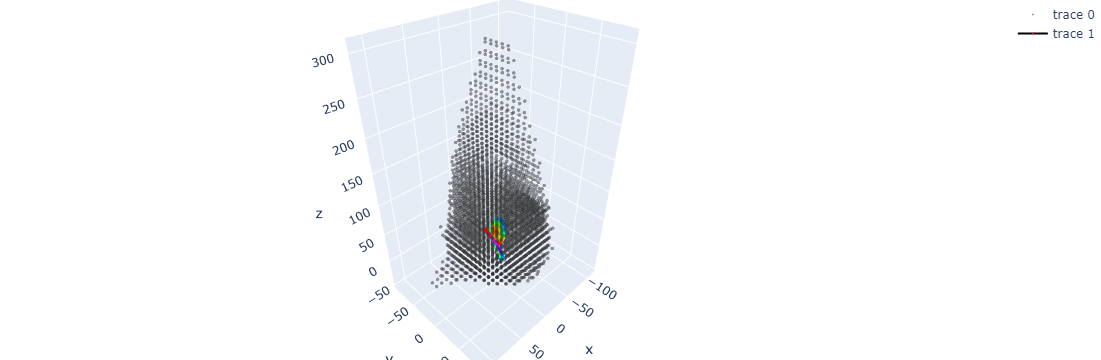

In [25]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import plotly

layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=[],layout=layout)

fig.update_layout(paper_bgcolor="rgba(0,0,0,0)", plot_bgcolor="rgba(0,0,0,0)")
fig.update_scenes(xaxis_visible=True, yaxis_visible=True,zaxis_visible=True )


X_surface = valid_starts_arr[:,0]
Y_surface = valid_starts_arr[:,1]
Z_surface = valid_starts_arr[:,2]

fig.add_trace(go.Scatter3d(x=X_surface, y=Y_surface, z=Z_surface, mode='markers', marker=dict(
                size=2,
                color='rgb(50,50,50)',
                opacity=0.5
                )
                 )
             )


X_surface = saved_data[:,0]
Y_surface = saved_data[:,1]
Z_surface = saved_data[:,2]

ρ = 28
σ = 10
β = 2.667


point1 = np.array([[np.sqrt(β*(ρ-1)), np.sqrt(β*(ρ-1)), ρ-1]])

point2 = np.array([[-np.sqrt(β*(ρ-1)), -np.sqrt(β*(ρ-1)), ρ-1]])

# point1 = np.array([root_1])

# point2 = np.array([root_2])

color = np.hstack([((data-point1)**2).sum(axis=1)[:, np.newaxis], ((data-point2)**2).sum(axis=1)[:, np.newaxis]])
color = color.min(axis=1)

fig.add_trace(go.Scatter3d(x=X_surface, y=Y_surface, z=Z_surface, marker=dict(
                size=2,
                color=color,
                colorscale='hsv',    
                ),
                line=dict(
                    color=color,
                    colorscale='hsv',
                    width=2)
                    
                 )
             )


fig.show()
# plotly.io.write_image(fig, f'lornezattractor.png', format=None, scale=None, width=None, height=None, validate=True, engine='auto')

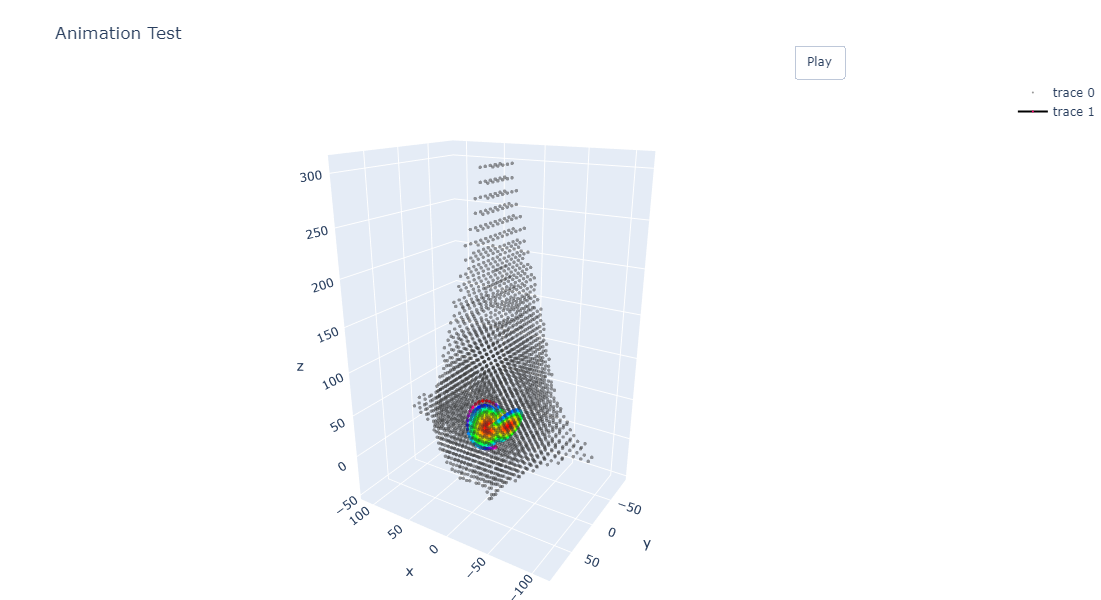

In [26]:
x_eye = -1.25
y_eye = 2
z_eye = 0.95

fig.update_layout(
         title='Animation Test',
         width=600,
         height=600,
         scene_camera_eye=dict(x=x_eye, y=y_eye, z=z_eye),
         updatemenus=[dict(type='buttons',
                  showactive=False,
                  y=1,
                  x=0.8,
                  xanchor='left',
                  yanchor='bottom',
                  pad=dict(t=45, r=10),
                  buttons=[dict(label='Play',
                                 method='animate',
                                 args=[None, dict(frame=dict(duration=5, redraw=True), 
                                                             transition=dict(duration=0),
                                                             fromcurrent=True,
                                                             mode='immediate'
                                                            )]
                                            )
                                      ]
                              )
                        ]
)


def rotate_z(x, y, z, theta):
    w = x+1j*y
    return np.real(np.exp(1j*theta)*w), np.imag(np.exp(1j*theta)*w), z

frames=[]
for t in np.arange(0, 6.26, 0.1):
    xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
    frames.append(go.Frame(layout=dict(scene_camera_eye=dict(x=xe, y=ye, z=ze))))
fig.frames=frames

fig.show()